# Classic methods of text classification

### Yelp Review Rating Classification

A machine learning project for sentiment analysis and rating prediction of Yelp reviews using TF-IDF feature extraction and neural networks.

### Project Overview

This project implements a multi-class classification system to predict Yelp review ratings (1-5 stars) based on review text. The solution combines traditional NLP feature extraction methods with neural network classifiers.

### Dataset

We use the **Yelp Review Full** dataset from Hugging Face:
- **Dataset**: [Yelp/yelp_review_full](https://huggingface.co/datasets/Yelp/yelp_review_full)
- **Features**:
  - `text`: The review text content
  - `label`: Rating label (0-4, corresponding to 1-5 stars respectively)

### Technical Approach

#### Data Preprocessing
- Split the original training data to create a dedicated validation set
- Applied dataset size constraints (training set limited to 100,000 samples)
- Maintained proportional splits for validation and test sets

#### Feature Extraction
- **TF-IDF (Term Frequency-Inverse Document Frequency)** implementation
- **Bag-of-Words** representation using `TfidfVectorizer` from `scikit-learn`
- Text vectorization for neural network compatibility



Import libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu121


In [2]:
import wandb

# Loging to Weights&Biases website to monitor my experiments
wandb.login()

c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

True

# Load dataset

In [3]:
from datasets import load_dataset

ds = load_dataset("Yelp/yelp_review_full")

test_dataset = ds["test"]
splitted_dataset = ds["train"].train_test_split(test_size=0.2)
train_dataset = splitted_dataset["train"]
val_dataset = splitted_dataset["test"]

# Create smaller data subsets
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset)*0.1)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset)*0.1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset)*0.4)))

print(f"Test set size: {len(test_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Training set size: {len(train_dataset)}")

sample = train_dataset[123]
print(f"\nExample element from the dataset:")
print(f"{sample['text']=}")
print(f"{sample['label']=}")

c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test set size: 20000
Validation set size: 13000
Training set size: 52000

Example element from the dataset:
sample['text']="Monta neighbors Nakamura-Ya, & Raku. With an authentic sushi place to join the strip mall, this is the spot to get some kick-butt Japanese food. Monta is a ramen-specialty restaurant that is not to be skipped!\\n\\nRAMEN: Their menu is small but mighty. What kind of ramen you like? Miso, Shoyu, or Tonkatsu? They come with thin slices of char-siu pork. Ichiza actually has my favorite char-siu.... but Monta's is a solid second. Overall, the ramen here is far superior anyway. There's also a variety of toppings you can add for an additional cost. Generally, I order the same thing every time: Miso Ramen w/ Egg & Nori. YUM! I've sampled every type of soup but Miso is my favorite. The broth is rich & flavorful and I can't find it as good anywhere else.\\n\\nAPPETIZERS: If fish eggs are your thing, Monta has the freshest Mentaiko in Las Vegas. Order a Mini Mentaiko Bowl (

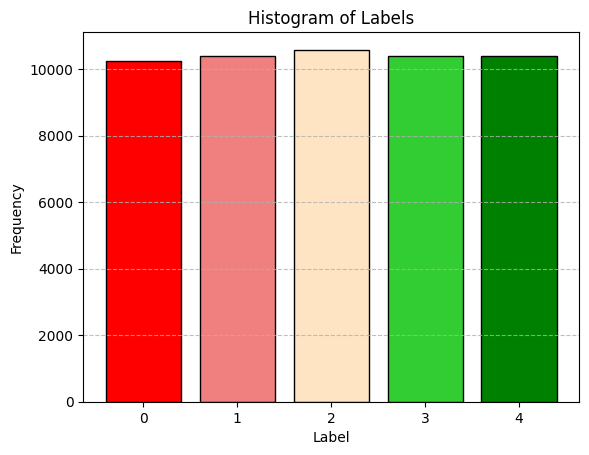

In [4]:
unique_labels, counts = np.unique(train_dataset["label"], return_counts=True)

plt.bar(unique_labels, counts, color=["red", "lightcoral", "bisque", "limegreen", "green"], edgecolor='black')
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from tqdm import tqdm

vocab_size = 10000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    analyzer='word',
    ngram_range=(1, 1),
    stop_words="english"
)

# Feature extraction
train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
# On validation and test sets we use transform() function which extracts the same features as on the training set
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

print(f"TF-IDF matrix size for training set: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Example features: {np.random.choice(feature_names, 20)}\n")

TF-IDF matrix size for training set: (52000, 10000)
train_tfidf_features.dtype=dtype('float64')

Number of features: 10000
Example features: ['queens' 'surgery' 'guns' 'nserver' 'concoctions' 'aus' 'u00fcr'
 'oriental' 'bouchon' 'worst' 'circuit' 'certainly' 'vegan' 'prices'
 'curiosity' 'pit' 'guessing' 'detroit' 'moon' 'scene']



Average number of non-zero features in samples: 47.87


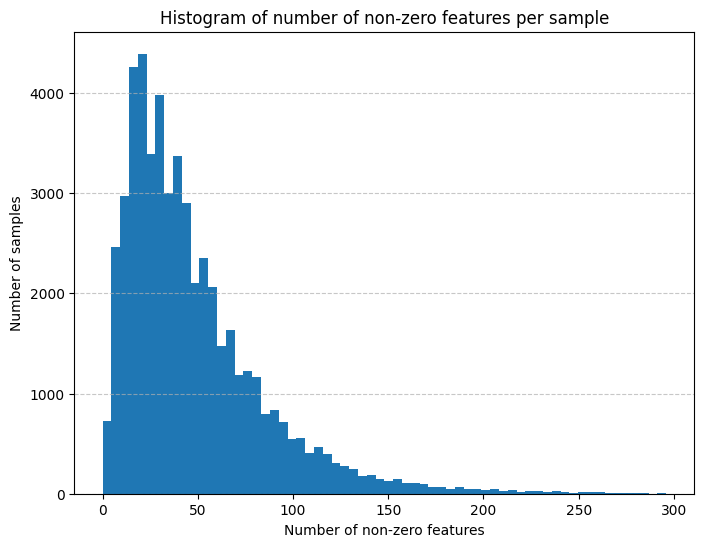

In [6]:
non_zero_counts = np.diff(train_tfidf_features.indptr)
print(f"Average number of non-zero features in samples: {non_zero_counts.mean():.2f}")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=64)
plt.title('Histogram of number of non-zero features per sample')
plt.xlabel('Number of non-zero features')
plt.ylabel('Number of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create appropriate datasets using tfidf matrices
def make_dataset(tfidf_matrix, labels):
  dense_features = tfidf_matrix.astype(np.float32).todense()
  dataset = TensorDataset(torch.tensor(dense_features), torch.tensor(labels, dtype=torch.int64))
  return dataset

datasets = {
    "train": make_dataset(train_tfidf_features, train_dataset["label"]),
    "val": make_dataset(val_tfidf_features, val_dataset["label"]),
    "test": make_dataset(test_tfidf_features, test_dataset["label"])
}


train_loader = DataLoader(datasets["train"], shuffle=True, batch_size=512)
val_loader = DataLoader(datasets["val"], shuffle=False, batch_size=512)
test_loader = DataLoader(datasets["test"], shuffle=False, batch_size=512)

loaders = {"train" : train_loader,
           "val": val_loader,
           "test": test_loader}

In [8]:
import torch.nn as nn

# Different architectures
class SimpleNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 128)
     self.fc2 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.batchNorm1 = nn.BatchNorm1d(128)
     self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    logits = self.dropout(self.relu(self.fc2(x)))
    return logits


class MediumNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 256)
     self.fc2 = nn.Linear(256, 128)
     self.fc3 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.dropout = nn.Dropout(0.2)
     self.batchNorm1 = nn.BatchNorm1d(256)
     self.batchNorm2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    logits = self.fc3(x)
    return logits

class LargeNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
    super().__init__()
    self.fc1 = nn.Linear(vocab_size, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.batchNorm1 = nn.BatchNorm1d(512)
    self.batchNorm2 = nn.BatchNorm1d(256)
    self.batchNorm3 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    x = self.dropout(self.relu(self.batchNorm3(self.fc3(x))))
    logits = self.fc4(x)
    return logits

In [18]:
import torchmetrics

# Training Loop
def train(model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, device):

  metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
  metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)
  earlyStopping = EarlyStopping(patience=5, delta=0.0001)

  # Run all epochs
  for epoch in range(1, num_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for X_batch, target in tqdm(loaders[phase]):
            X_batch, target = X_batch.to(device), target.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits = model(X_batch)
                _, preds = torch.max(logits, dim=1)
                loss = criterion(logits, target)

                metric_loss(loss)
                metric_acc(preds, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    lr_scheduler.step()

        accuracy = metric_acc.compute()
        mean_loss = metric_loss.compute()

        current_lr = lr_scheduler.get_last_lr()[0]
        print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {accuracy:.3f}   lr: {current_lr}")
        metrics = {
            f"{phase}/loss": mean_loss,
            f"{phase}/accuracy": accuracy,
            f"{phase}/lr": current_lr,
        }
        wandb.log(metrics, step=epoch)

        metric_loss.reset()
        metric_acc.reset()

    earlyStopping(mean_loss, model)
    if earlyStopping.early_stop:
      print(f"{20*'-'}Early stopping{20*'-'}")
      break
    #lr_scheduler.step()

  earlyStopping.load_best_model(model)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)




In [24]:
# Setting methods and parameters for training

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

num_epochs = 50
criterion = nn.CrossEntropyLoss()
classifiers = {"model1" : SimpleNet(vocab_size, 5),
               "model2" : MediumNet(vocab_size, 5),
               "model3" : LargeNet(vocab_size, 5)}


for name, model in classifiers.items():
  print(f"Trenowanie modelu: {name}")
  model = model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(train_loader), epochs=num_epochs)
  run = wandb.init(
    project="3DifferentNeuralNetsExperiments_v13",
    name=name,
    config={
        "model": name,
        "vocab_size": vocab_size,
        "num_classes": 5,
        "optimizer": "AdamW",
        "lr": 1e-6,
        "weight_decay": 1e-3,
        "scheduler": "OneCycleLR",
        "max_lr": 1e-5,
        "num_epochs": num_epochs
    }
  )
  train(model, loaders, criterion, optimizer, lr_scheduler, num_epochs, device)
  run.finish()


Trenowanie modelu: model1


100%|██████████| 102/102 [00:02<00:00, 44.47it/s]


(Epoch 1/[train]) Loss:	1.635   Accuracy: 0.204   lr: 5.050282613936265e-07


100%|██████████| 26/26 [00:00<00:00, 56.36it/s]


(Epoch 1/[val]) Loss:	1.618   Accuracy: 0.206   lr: 5.050282613936265e-07


100%|██████████| 102/102 [00:02<00:00, 45.05it/s]


(Epoch 2/[train]) Loss:	1.632   Accuracy: 0.206   lr: 8.155168223697683e-07


100%|██████████| 26/26 [00:00<00:00, 55.28it/s]


(Epoch 2/[val]) Loss:	1.619   Accuracy: 0.210   lr: 8.155168223697683e-07


100%|██████████| 102/102 [00:02<00:00, 44.53it/s]


(Epoch 3/[train]) Loss:	1.628   Accuracy: 0.212   lr: 1.3178781522026197e-06


100%|██████████| 26/26 [00:00<00:00, 57.30it/s]


(Epoch 3/[val]) Loss:	1.615   Accuracy: 0.217   lr: 1.3178781522026197e-06


100%|██████████| 102/102 [00:02<00:00, 44.46it/s]


(Epoch 4/[train]) Loss:	1.621   Accuracy: 0.222   lr: 1.990128027115625e-06


100%|██████████| 26/26 [00:00<00:00, 57.70it/s]


(Epoch 4/[val]) Loss:	1.608   Accuracy: 0.229   lr: 1.990128027115625e-06


100%|██████████| 102/102 [00:02<00:00, 42.80it/s]


(Epoch 5/[train]) Loss:	1.612   Accuracy: 0.234   lr: 2.8028475989487054e-06


100%|██████████| 26/26 [00:00<00:00, 54.03it/s]


(Epoch 5/[val]) Loss:	1.597   Accuracy: 0.247   lr: 2.8028475989487054e-06


100%|██████████| 102/102 [00:02<00:00, 46.07it/s]


(Epoch 6/[train]) Loss:	1.596   Accuracy: 0.255   lr: 3.720470816189275e-06


100%|██████████| 26/26 [00:00<00:00, 54.22it/s]


(Epoch 6/[val]) Loss:	1.583   Accuracy: 0.275   lr: 3.720470816189275e-06


100%|██████████| 102/102 [00:02<00:00, 45.47it/s]


(Epoch 7/[train]) Loss:	1.577   Accuracy: 0.278   lr: 4.70284085753683e-06


100%|██████████| 26/26 [00:00<00:00, 56.81it/s]


(Epoch 7/[val]) Loss:	1.562   Accuracy: 0.309   lr: 4.70284085753683e-06


100%|██████████| 102/102 [00:02<00:00, 47.14it/s]


(Epoch 8/[train]) Loss:	1.552   Accuracy: 0.311   lr: 5.706967465704742e-06


100%|██████████| 26/26 [00:00<00:00, 57.11it/s]


(Epoch 8/[val]) Loss:	1.536   Accuracy: 0.347   lr: 5.706967465704742e-06


100%|██████████| 102/102 [00:02<00:00, 46.96it/s]


(Epoch 9/[train]) Loss:	1.519   Accuracy: 0.346   lr: 6.688908277411779e-06


100%|██████████| 26/26 [00:00<00:00, 57.55it/s]


(Epoch 9/[val]) Loss:	1.504   Accuracy: 0.382   lr: 6.688908277411779e-06


100%|██████████| 102/102 [00:02<00:00, 47.31it/s]


(Epoch 10/[train]) Loss:	1.484   Accuracy: 0.379   lr: 7.605691819222507e-06


100%|██████████| 26/26 [00:00<00:00, 54.73it/s]


(Epoch 10/[val]) Loss:	1.469   Accuracy: 0.413   lr: 7.605691819222507e-06


100%|██████████| 102/102 [00:02<00:00, 44.19it/s]


(Epoch 11/[train]) Loss:	1.447   Accuracy: 0.404   lr: 8.417198015524148e-06


100%|██████████| 26/26 [00:00<00:00, 59.15it/s]


(Epoch 11/[val]) Loss:	1.434   Accuracy: 0.437   lr: 8.417198015524148e-06


100%|██████████| 102/102 [00:02<00:00, 47.08it/s]


(Epoch 12/[train]) Loss:	1.410   Accuracy: 0.434   lr: 9.08791391427182e-06


100%|██████████| 26/26 [00:00<00:00, 58.52it/s]


(Epoch 12/[val]) Loss:	1.402   Accuracy: 0.453   lr: 9.08791391427182e-06


100%|██████████| 102/102 [00:02<00:00, 47.32it/s]


(Epoch 13/[train]) Loss:	1.375   Accuracy: 0.454   lr: 9.588487796826136e-06


100%|██████████| 26/26 [00:00<00:00, 58.29it/s]


(Epoch 13/[val]) Loss:	1.372   Accuracy: 0.467   lr: 9.588487796826136e-06


100%|██████████| 102/102 [00:02<00:00, 46.35it/s]


(Epoch 14/[train]) Loss:	1.343   Accuracy: 0.470   lr: 9.897013661277203e-06


100%|██████████| 26/26 [00:00<00:00, 57.14it/s]


(Epoch 14/[val]) Loss:	1.344   Accuracy: 0.477   lr: 9.897013661277203e-06


100%|██████████| 102/102 [00:02<00:00, 47.00it/s]


(Epoch 15/[train]) Loss:	1.316   Accuracy: 0.487   lr: 9.999998064016924e-06


100%|██████████| 26/26 [00:00<00:00, 56.34it/s]


(Epoch 15/[val]) Loss:	1.322   Accuracy: 0.487   lr: 9.999998064016924e-06


100%|██████████| 102/102 [00:02<00:00, 44.84it/s]


(Epoch 16/[train]) Loss:	1.287   Accuracy: 0.504   lr: 9.979475211892622e-06


100%|██████████| 26/26 [00:00<00:00, 49.47it/s]


(Epoch 16/[val]) Loss:	1.301   Accuracy: 0.495   lr: 9.979475211892622e-06


100%|██████████| 102/102 [00:02<00:00, 38.43it/s]


(Epoch 17/[train]) Loss:	1.262   Accuracy: 0.519   lr: 9.918860714274414e-06


100%|██████████| 26/26 [00:00<00:00, 36.92it/s]


(Epoch 17/[val]) Loss:	1.283   Accuracy: 0.500   lr: 9.918860714274414e-06


100%|██████████| 102/102 [00:02<00:00, 40.74it/s]


(Epoch 18/[train]) Loss:	1.242   Accuracy: 0.527   lr: 9.818642603456368e-06


100%|██████████| 26/26 [00:00<00:00, 50.04it/s]


(Epoch 18/[val]) Loss:	1.268   Accuracy: 0.506   lr: 9.818642603456368e-06


100%|██████████| 102/102 [00:02<00:00, 41.41it/s]


(Epoch 19/[train]) Loss:	1.222   Accuracy: 0.539   lr: 9.6796277767395e-06


100%|██████████| 26/26 [00:00<00:00, 53.96it/s]


(Epoch 19/[val]) Loss:	1.255   Accuracy: 0.511   lr: 9.6796277767395e-06


100%|██████████| 102/102 [00:02<00:00, 42.18it/s]


(Epoch 20/[train]) Loss:	1.206   Accuracy: 0.546   lr: 9.502935499769142e-06


100%|██████████| 26/26 [00:00<00:00, 44.92it/s]


(Epoch 20/[val]) Loss:	1.243   Accuracy: 0.516   lr: 9.502935499769142e-06


100%|██████████| 102/102 [00:02<00:00, 46.83it/s]


(Epoch 21/[train]) Loss:	1.190   Accuracy: 0.554   lr: 9.289988394866079e-06


100%|██████████| 26/26 [00:00<00:00, 55.93it/s]


(Epoch 21/[val]) Loss:	1.233   Accuracy: 0.518   lr: 9.289988394866079e-06


100%|██████████| 102/102 [00:02<00:00, 45.55it/s]


(Epoch 22/[train]) Loss:	1.174   Accuracy: 0.562   lr: 9.04250098690812e-06


100%|██████████| 26/26 [00:00<00:00, 54.56it/s]


(Epoch 22/[val]) Loss:	1.224   Accuracy: 0.520   lr: 9.04250098690812e-06


100%|██████████| 102/102 [00:02<00:00, 44.40it/s]


(Epoch 23/[train]) Loss:	1.162   Accuracy: 0.568   lr: 8.762465898983908e-06


100%|██████████| 26/26 [00:00<00:00, 57.94it/s]


(Epoch 23/[val]) Loss:	1.217   Accuracy: 0.523   lr: 8.762465898983908e-06


100%|██████████| 102/102 [00:02<00:00, 44.67it/s]


(Epoch 24/[train]) Loss:	1.147   Accuracy: 0.575   lr: 8.452137808963437e-06


100%|██████████| 26/26 [00:00<00:00, 43.03it/s]


(Epoch 24/[val]) Loss:	1.210   Accuracy: 0.524   lr: 8.452137808963437e-06


100%|██████████| 102/102 [00:02<00:00, 46.43it/s]


(Epoch 25/[train]) Loss:	1.136   Accuracy: 0.581   lr: 8.114015296157596e-06


100%|██████████| 26/26 [00:00<00:00, 54.52it/s]


(Epoch 25/[val]) Loss:	1.203   Accuracy: 0.526   lr: 8.114015296157596e-06


100%|██████████| 102/102 [00:02<00:00, 45.75it/s]


(Epoch 26/[train]) Loss:	1.125   Accuracy: 0.586   lr: 7.750820724226675e-06


100%|██████████| 26/26 [00:00<00:00, 55.88it/s]


(Epoch 26/[val]) Loss:	1.199   Accuracy: 0.528   lr: 7.750820724226675e-06


100%|██████████| 102/102 [00:02<00:00, 45.04it/s]


(Epoch 27/[train]) Loss:	1.118   Accuracy: 0.590   lr: 7.365478322308915e-06


100%|██████████| 26/26 [00:00<00:00, 51.17it/s]


(Epoch 27/[val]) Loss:	1.194   Accuracy: 0.529   lr: 7.365478322308915e-06


100%|██████████| 102/102 [00:02<00:00, 39.35it/s]


(Epoch 28/[train]) Loss:	1.111   Accuracy: 0.593   lr: 6.961090640846892e-06


100%|██████████| 26/26 [00:00<00:00, 52.04it/s]


(Epoch 28/[val]) Loss:	1.189   Accuracy: 0.529   lr: 6.961090640846892e-06


100%|██████████| 102/102 [00:02<00:00, 46.85it/s]


(Epoch 29/[train]) Loss:	1.102   Accuracy: 0.597   lr: 6.540913571675635e-06


100%|██████████| 26/26 [00:00<00:00, 51.25it/s]


(Epoch 29/[val]) Loss:	1.186   Accuracy: 0.529   lr: 6.540913571675635e-06


100%|██████████| 102/102 [00:02<00:00, 45.14it/s]


(Epoch 30/[train]) Loss:	1.088   Accuracy: 0.604   lr: 6.108330133495993e-06


100%|██████████| 26/26 [00:00<00:00, 54.13it/s]


(Epoch 30/[val]) Loss:	1.184   Accuracy: 0.530   lr: 6.108330133495993e-06


100%|██████████| 102/102 [00:02<00:00, 39.61it/s]


(Epoch 31/[train]) Loss:	1.087   Accuracy: 0.607   lr: 5.6668232337972465e-06


100%|██████████| 26/26 [00:00<00:00, 37.86it/s]


(Epoch 31/[val]) Loss:	1.180   Accuracy: 0.532   lr: 5.6668232337972465e-06


100%|██████████| 102/102 [00:02<00:00, 41.34it/s]


(Epoch 32/[train]) Loss:	1.081   Accuracy: 0.607   lr: 5.219947626533917e-06


100%|██████████| 26/26 [00:00<00:00, 55.92it/s]


(Epoch 32/[val]) Loss:	1.178   Accuracy: 0.532   lr: 5.219947626533917e-06


100%|██████████| 102/102 [00:02<00:00, 43.03it/s]


(Epoch 33/[train]) Loss:	1.072   Accuracy: 0.612   lr: 4.771301291337086e-06


100%|██████████| 26/26 [00:00<00:00, 53.39it/s]


(Epoch 33/[val]) Loss:	1.176   Accuracy: 0.532   lr: 4.771301291337086e-06


100%|██████████| 102/102 [00:02<00:00, 46.57it/s]


(Epoch 34/[train]) Loss:	1.063   Accuracy: 0.618   lr: 4.324496464697987e-06


100%|██████████| 26/26 [00:00<00:00, 58.29it/s]


(Epoch 34/[val]) Loss:	1.175   Accuracy: 0.532   lr: 4.324496464697987e-06


100%|██████████| 102/102 [00:02<00:00, 46.86it/s]


(Epoch 35/[train]) Loss:	1.063   Accuracy: 0.618   lr: 3.8831305563637325e-06


100%|██████████| 26/26 [00:00<00:00, 51.34it/s]


(Epoch 35/[val]) Loss:	1.173   Accuracy: 0.532   lr: 3.8831305563637325e-06


100%|██████████| 102/102 [00:02<00:00, 47.12it/s]


(Epoch 36/[train]) Loss:	1.063   Accuracy: 0.617   lr: 3.4507571851092788e-06


100%|██████████| 26/26 [00:00<00:00, 58.14it/s]


(Epoch 36/[val]) Loss:	1.172   Accuracy: 0.532   lr: 3.4507571851092788e-06


100%|██████████| 102/102 [00:02<00:00, 45.72it/s]


(Epoch 37/[train]) Loss:	1.053   Accuracy: 0.623   lr: 3.0308575670885416e-06


100%|██████████| 26/26 [00:00<00:00, 52.31it/s]


(Epoch 37/[val]) Loss:	1.170   Accuracy: 0.531   lr: 3.0308575670885416e-06


100%|██████████| 102/102 [00:02<00:00, 43.51it/s]


(Epoch 38/[train]) Loss:	1.052   Accuracy: 0.623   lr: 2.6268124871288486e-06


100%|██████████| 26/26 [00:00<00:00, 57.06it/s]


(Epoch 38/[val]) Loss:	1.170   Accuracy: 0.532   lr: 2.6268124871288486e-06


100%|██████████| 102/102 [00:02<00:00, 45.98it/s]


(Epoch 39/[train]) Loss:	1.048   Accuracy: 0.625   lr: 2.2418750786393736e-06


100%|██████████| 26/26 [00:00<00:00, 55.99it/s]


(Epoch 39/[val]) Loss:	1.169   Accuracy: 0.533   lr: 2.2418750786393736e-06


100%|██████████| 102/102 [00:02<00:00, 46.02it/s]


(Epoch 40/[train]) Loss:	1.044   Accuracy: 0.626   lr: 1.8791446312937438e-06


100%|██████████| 26/26 [00:00<00:00, 57.66it/s]


(Epoch 40/[val]) Loss:	1.168   Accuracy: 0.533   lr: 1.8791446312937438e-06


100%|██████████| 102/102 [00:02<00:00, 46.71it/s]


(Epoch 41/[train]) Loss:	1.042   Accuracy: 0.626   lr: 1.5415416373719365e-06


100%|██████████| 26/26 [00:00<00:00, 53.72it/s]


(Epoch 41/[val]) Loss:	1.168   Accuracy: 0.532   lr: 1.5415416373719365e-06


100%|██████████| 102/102 [00:02<00:00, 46.61it/s]


(Epoch 42/[train]) Loss:	1.040   Accuracy: 0.627   lr: 1.2317842776736646e-06


100%|██████████| 26/26 [00:00<00:00, 51.38it/s]


(Epoch 42/[val]) Loss:	1.168   Accuracy: 0.533   lr: 1.2317842776736646e-06


100%|██████████| 102/102 [00:02<00:00, 45.27it/s]


(Epoch 43/[train]) Loss:	1.040   Accuracy: 0.627   lr: 9.52366536324841e-07


100%|██████████| 26/26 [00:00<00:00, 51.69it/s]


(Epoch 43/[val]) Loss:	1.168   Accuracy: 0.533   lr: 9.52366536324841e-07


100%|██████████| 102/102 [00:02<00:00, 39.06it/s]


(Epoch 44/[train]) Loss:	1.037   Accuracy: 0.628   lr: 7.05538120683834e-07


100%|██████████| 26/26 [00:00<00:00, 62.75it/s]


(Epoch 44/[val]) Loss:	1.167   Accuracy: 0.532   lr: 7.05538120683834e-07


100%|██████████| 102/102 [00:01<00:00, 57.76it/s]


(Epoch 45/[train]) Loss:	1.036   Accuracy: 0.631   lr: 4.932863480206282e-07


100%|██████████| 26/26 [00:00<00:00, 67.16it/s]


(Epoch 45/[val]) Loss:	1.167   Accuracy: 0.533   lr: 4.932863480206282e-07


100%|██████████| 102/102 [00:01<00:00, 53.93it/s]


(Epoch 46/[train]) Loss:	1.041   Accuracy: 0.627   lr: 3.173201448066853e-07


100%|██████████| 26/26 [00:00<00:00, 55.27it/s]


(Epoch 46/[val]) Loss:	1.167   Accuracy: 0.534   lr: 3.173201448066853e-07


100%|██████████| 102/102 [00:02<00:00, 43.92it/s]


(Epoch 47/[train]) Loss:	1.039   Accuracy: 0.628   lr: 1.7905628744383255e-07


100%|██████████| 26/26 [00:00<00:00, 52.80it/s]


(Epoch 47/[val]) Loss:	1.167   Accuracy: 0.533   lr: 1.7905628744383255e-07


100%|██████████| 102/102 [00:02<00:00, 41.52it/s]


(Epoch 48/[train]) Loss:	1.037   Accuracy: 0.631   lr: 7.960799521372398e-08


100%|██████████| 26/26 [00:00<00:00, 45.34it/s]


(Epoch 48/[val]) Loss:	1.166   Accuracy: 0.533   lr: 7.960799521372398e-08


100%|██████████| 102/102 [00:02<00:00, 42.48it/s]


(Epoch 49/[train]) Loss:	1.040   Accuracy: 0.627   lr: 1.977596729074781e-08


100%|██████████| 26/26 [00:00<00:00, 54.62it/s]


(Epoch 49/[val]) Loss:	1.167   Accuracy: 0.534   lr: 1.977596729074781e-08


100%|██████████| 102/102 [00:02<00:00, 43.70it/s]


(Epoch 50/[train]) Loss:	1.038   Accuracy: 0.628   lr: 4.1935983076470884e-11


100%|██████████| 26/26 [00:00<00:00, 55.65it/s]

(Epoch 50/[val]) Loss:	1.167   Accuracy: 0.534   lr: 4.1935983076470884e-11


train/accuracy,▁▁▁▁▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████
train/loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▂▂▂▃▄▅▆▆███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val/accuracy,▁▁▁▁▂▃▄▅▅▆▇▇▇▇▇█████████████████████████
val/loss,█████▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,▁▂▂▂▃▄▅▆▆▇████████▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁▁▁▁
train/accuracy,0.62844
train/loss,1.03772
train/lr,0.0
val/accuracy,0.53369
val/loss,1.16672


Trenowanie modelu: model2


100%|██████████| 102/102 [00:03<00:00, 32.56it/s]


(Epoch 1/[train]) Loss:	1.708   Accuracy: 0.194   lr: 5.050282613936265e-07


100%|██████████| 26/26 [00:00<00:00, 43.23it/s]


(Epoch 1/[val]) Loss:	1.647   Accuracy: 0.194   lr: 5.050282613936265e-07


100%|██████████| 102/102 [00:03<00:00, 31.07it/s]


(Epoch 2/[train]) Loss:	1.706   Accuracy: 0.195   lr: 8.155168223697683e-07


100%|██████████| 26/26 [00:00<00:00, 48.68it/s]


(Epoch 2/[val]) Loss:	1.659   Accuracy: 0.200   lr: 8.155168223697683e-07


100%|██████████| 102/102 [00:02<00:00, 36.04it/s]


(Epoch 3/[train]) Loss:	1.698   Accuracy: 0.203   lr: 1.3178781522026197e-06


100%|██████████| 26/26 [00:00<00:00, 45.86it/s]


(Epoch 3/[val]) Loss:	1.649   Accuracy: 0.210   lr: 1.3178781522026197e-06


100%|██████████| 102/102 [00:02<00:00, 37.96it/s]


(Epoch 4/[train]) Loss:	1.681   Accuracy: 0.214   lr: 1.990128027115625e-06


100%|██████████| 26/26 [00:00<00:00, 50.18it/s]


(Epoch 4/[val]) Loss:	1.634   Accuracy: 0.226   lr: 1.990128027115625e-06


100%|██████████| 102/102 [00:02<00:00, 38.45it/s]


(Epoch 5/[train]) Loss:	1.661   Accuracy: 0.229   lr: 2.8028475989487054e-06


100%|██████████| 26/26 [00:00<00:00, 52.12it/s]


(Epoch 5/[val]) Loss:	1.613   Accuracy: 0.251   lr: 2.8028475989487054e-06


100%|██████████| 102/102 [00:02<00:00, 36.66it/s]


(Epoch 6/[train]) Loss:	1.632   Accuracy: 0.252   lr: 3.720470816189275e-06


100%|██████████| 26/26 [00:00<00:00, 51.59it/s]


(Epoch 6/[val]) Loss:	1.586   Accuracy: 0.280   lr: 3.720470816189275e-06


100%|██████████| 102/102 [00:02<00:00, 38.83it/s]


(Epoch 7/[train]) Loss:	1.594   Accuracy: 0.282   lr: 4.70284085753683e-06


100%|██████████| 26/26 [00:00<00:00, 47.55it/s]


(Epoch 7/[val]) Loss:	1.553   Accuracy: 0.312   lr: 4.70284085753683e-06


100%|██████████| 102/102 [00:02<00:00, 37.95it/s]


(Epoch 8/[train]) Loss:	1.552   Accuracy: 0.314   lr: 5.706967465704742e-06


100%|██████████| 26/26 [00:00<00:00, 51.18it/s]


(Epoch 8/[val]) Loss:	1.516   Accuracy: 0.345   lr: 5.706967465704742e-06


100%|██████████| 102/102 [00:02<00:00, 38.54it/s]


(Epoch 9/[train]) Loss:	1.501   Accuracy: 0.350   lr: 6.688908277411779e-06


100%|██████████| 26/26 [00:00<00:00, 50.79it/s]


(Epoch 9/[val]) Loss:	1.474   Accuracy: 0.378   lr: 6.688908277411779e-06


100%|██████████| 102/102 [00:02<00:00, 37.54it/s]


(Epoch 10/[train]) Loss:	1.451   Accuracy: 0.388   lr: 7.605691819222507e-06


100%|██████████| 26/26 [00:00<00:00, 51.32it/s]


(Epoch 10/[val]) Loss:	1.430   Accuracy: 0.406   lr: 7.605691819222507e-06


100%|██████████| 102/102 [00:02<00:00, 38.08it/s]


(Epoch 11/[train]) Loss:	1.392   Accuracy: 0.430   lr: 8.417198015524148e-06


100%|██████████| 26/26 [00:00<00:00, 51.49it/s]


(Epoch 11/[val]) Loss:	1.384   Accuracy: 0.430   lr: 8.417198015524148e-06


100%|██████████| 102/102 [00:02<00:00, 36.25it/s]


(Epoch 12/[train]) Loss:	1.337   Accuracy: 0.462   lr: 9.08791391427182e-06


100%|██████████| 26/26 [00:00<00:00, 49.20it/s]


(Epoch 12/[val]) Loss:	1.340   Accuracy: 0.452   lr: 9.08791391427182e-06


100%|██████████| 102/102 [00:02<00:00, 37.58it/s]


(Epoch 13/[train]) Loss:	1.281   Accuracy: 0.493   lr: 9.588487796826136e-06


100%|██████████| 26/26 [00:00<00:00, 49.97it/s]


(Epoch 13/[val]) Loss:	1.300   Accuracy: 0.469   lr: 9.588487796826136e-06


100%|██████████| 102/102 [00:02<00:00, 38.90it/s]


(Epoch 14/[train]) Loss:	1.230   Accuracy: 0.523   lr: 9.897013661277203e-06


100%|██████████| 26/26 [00:00<00:00, 51.87it/s]


(Epoch 14/[val]) Loss:	1.264   Accuracy: 0.483   lr: 9.897013661277203e-06


100%|██████████| 102/102 [00:02<00:00, 34.89it/s]


(Epoch 15/[train]) Loss:	1.180   Accuracy: 0.549   lr: 9.999998064016924e-06


100%|██████████| 26/26 [00:00<00:00, 52.61it/s]


(Epoch 15/[val]) Loss:	1.232   Accuracy: 0.496   lr: 9.999998064016924e-06


100%|██████████| 102/102 [00:03<00:00, 32.43it/s]


(Epoch 16/[train]) Loss:	1.139   Accuracy: 0.572   lr: 9.979475211892622e-06


100%|██████████| 26/26 [00:00<00:00, 45.58it/s]


(Epoch 16/[val]) Loss:	1.205   Accuracy: 0.504   lr: 9.979475211892622e-06


100%|██████████| 102/102 [00:02<00:00, 41.25it/s]


(Epoch 17/[train]) Loss:	1.098   Accuracy: 0.592   lr: 9.918860714274414e-06


100%|██████████| 26/26 [00:00<00:00, 52.77it/s]


(Epoch 17/[val]) Loss:	1.182   Accuracy: 0.512   lr: 9.918860714274414e-06


100%|██████████| 102/102 [00:02<00:00, 48.13it/s]


(Epoch 18/[train]) Loss:	1.064   Accuracy: 0.609   lr: 9.818642603456368e-06


100%|██████████| 26/26 [00:00<00:00, 49.17it/s]


(Epoch 18/[val]) Loss:	1.163   Accuracy: 0.518   lr: 9.818642603456368e-06


100%|██████████| 102/102 [00:02<00:00, 35.79it/s]


(Epoch 19/[train]) Loss:	1.029   Accuracy: 0.627   lr: 9.6796277767395e-06


100%|██████████| 26/26 [00:00<00:00, 48.79it/s]


(Epoch 19/[val]) Loss:	1.146   Accuracy: 0.523   lr: 9.6796277767395e-06


100%|██████████| 102/102 [00:03<00:00, 33.89it/s]


(Epoch 20/[train]) Loss:	1.000   Accuracy: 0.642   lr: 9.502935499769142e-06


100%|██████████| 26/26 [00:00<00:00, 32.01it/s]


(Epoch 20/[val]) Loss:	1.133   Accuracy: 0.527   lr: 9.502935499769142e-06


100%|██████████| 102/102 [00:03<00:00, 33.43it/s]


(Epoch 21/[train]) Loss:	0.973   Accuracy: 0.656   lr: 9.289988394866079e-06


100%|██████████| 26/26 [00:00<00:00, 52.15it/s]


(Epoch 21/[val]) Loss:	1.123   Accuracy: 0.528   lr: 9.289988394866079e-06


100%|██████████| 102/102 [00:02<00:00, 39.24it/s]


(Epoch 22/[train]) Loss:	0.948   Accuracy: 0.669   lr: 9.04250098690812e-06


100%|██████████| 26/26 [00:00<00:00, 51.81it/s]


(Epoch 22/[val]) Loss:	1.112   Accuracy: 0.531   lr: 9.04250098690812e-06


100%|██████████| 102/102 [00:02<00:00, 36.12it/s]


(Epoch 23/[train]) Loss:	0.923   Accuracy: 0.681   lr: 8.762465898983908e-06


100%|██████████| 26/26 [00:00<00:00, 50.82it/s]


(Epoch 23/[val]) Loss:	1.106   Accuracy: 0.532   lr: 8.762465898983908e-06


100%|██████████| 102/102 [00:02<00:00, 38.15it/s]


(Epoch 24/[train]) Loss:	0.900   Accuracy: 0.690   lr: 8.452137808963437e-06


100%|██████████| 26/26 [00:00<00:00, 50.89it/s]


(Epoch 24/[val]) Loss:	1.097   Accuracy: 0.535   lr: 8.452137808963437e-06


100%|██████████| 102/102 [00:02<00:00, 38.77it/s]


(Epoch 25/[train]) Loss:	0.878   Accuracy: 0.703   lr: 8.114015296157596e-06


100%|██████████| 26/26 [00:00<00:00, 52.48it/s]


(Epoch 25/[val]) Loss:	1.092   Accuracy: 0.536   lr: 8.114015296157596e-06


100%|██████████| 102/102 [00:02<00:00, 38.55it/s]


(Epoch 26/[train]) Loss:	0.859   Accuracy: 0.711   lr: 7.750820724226675e-06


100%|██████████| 26/26 [00:00<00:00, 39.22it/s]


(Epoch 26/[val]) Loss:	1.088   Accuracy: 0.537   lr: 7.750820724226675e-06


100%|██████████| 102/102 [00:02<00:00, 38.57it/s]


(Epoch 27/[train]) Loss:	0.839   Accuracy: 0.721   lr: 7.365478322308915e-06


100%|██████████| 26/26 [00:00<00:00, 50.82it/s]


(Epoch 27/[val]) Loss:	1.084   Accuracy: 0.538   lr: 7.365478322308915e-06


100%|██████████| 102/102 [00:02<00:00, 38.53it/s]


(Epoch 28/[train]) Loss:	0.821   Accuracy: 0.732   lr: 6.961090640846892e-06


100%|██████████| 26/26 [00:00<00:00, 52.32it/s]


(Epoch 28/[val]) Loss:	1.082   Accuracy: 0.538   lr: 6.961090640846892e-06


100%|██████████| 102/102 [00:02<00:00, 38.63it/s]


(Epoch 29/[train]) Loss:	0.805   Accuracy: 0.737   lr: 6.540913571675635e-06


100%|██████████| 26/26 [00:00<00:00, 51.82it/s]


(Epoch 29/[val]) Loss:	1.080   Accuracy: 0.538   lr: 6.540913571675635e-06


100%|██████████| 102/102 [00:02<00:00, 38.76it/s]


(Epoch 30/[train]) Loss:	0.789   Accuracy: 0.748   lr: 6.108330133495993e-06


100%|██████████| 26/26 [00:00<00:00, 51.52it/s]


(Epoch 30/[val]) Loss:	1.078   Accuracy: 0.538   lr: 6.108330133495993e-06


100%|██████████| 102/102 [00:02<00:00, 38.70it/s]


(Epoch 31/[train]) Loss:	0.773   Accuracy: 0.754   lr: 5.6668232337972465e-06


100%|██████████| 26/26 [00:00<00:00, 51.02it/s]


(Epoch 31/[val]) Loss:	1.077   Accuracy: 0.539   lr: 5.6668232337972465e-06


100%|██████████| 102/102 [00:02<00:00, 36.75it/s]


(Epoch 32/[train]) Loss:	0.760   Accuracy: 0.760   lr: 5.219947626533917e-06


100%|██████████| 26/26 [00:00<00:00, 48.82it/s]


(Epoch 32/[val]) Loss:	1.077   Accuracy: 0.540   lr: 5.219947626533917e-06


100%|██████████| 102/102 [00:02<00:00, 38.93it/s]


(Epoch 33/[train]) Loss:	0.749   Accuracy: 0.766   lr: 4.771301291337086e-06


100%|██████████| 26/26 [00:00<00:00, 51.01it/s]


(Epoch 33/[val]) Loss:	1.076   Accuracy: 0.538   lr: 4.771301291337086e-06


100%|██████████| 102/102 [00:02<00:00, 38.68it/s]


(Epoch 34/[train]) Loss:	0.738   Accuracy: 0.770   lr: 4.324496464697987e-06


100%|██████████| 26/26 [00:00<00:00, 51.75it/s]


(Epoch 34/[val]) Loss:	1.076   Accuracy: 0.538   lr: 4.324496464697987e-06


100%|██████████| 102/102 [00:02<00:00, 38.80it/s]


(Epoch 35/[train]) Loss:	0.726   Accuracy: 0.777   lr: 3.8831305563637325e-06


100%|██████████| 26/26 [00:00<00:00, 51.61it/s]


(Epoch 35/[val]) Loss:	1.075   Accuracy: 0.538   lr: 3.8831305563637325e-06


100%|██████████| 102/102 [00:02<00:00, 38.03it/s]


(Epoch 36/[train]) Loss:	0.719   Accuracy: 0.777   lr: 3.4507571851092788e-06


100%|██████████| 26/26 [00:00<00:00, 51.67it/s]


(Epoch 36/[val]) Loss:	1.075   Accuracy: 0.538   lr: 3.4507571851092788e-06


100%|██████████| 102/102 [00:02<00:00, 38.47it/s]


(Epoch 37/[train]) Loss:	0.709   Accuracy: 0.787   lr: 3.0308575670885416e-06


100%|██████████| 26/26 [00:00<00:00, 51.79it/s]


(Epoch 37/[val]) Loss:	1.075   Accuracy: 0.538   lr: 3.0308575670885416e-06


100%|██████████| 102/102 [00:02<00:00, 36.65it/s]


(Epoch 38/[train]) Loss:	0.702   Accuracy: 0.789   lr: 2.6268124871288486e-06


100%|██████████| 26/26 [00:00<00:00, 53.40it/s]


(Epoch 38/[val]) Loss:	1.076   Accuracy: 0.538   lr: 2.6268124871288486e-06


100%|██████████| 102/102 [00:02<00:00, 38.56it/s]


(Epoch 39/[train]) Loss:	0.696   Accuracy: 0.794   lr: 2.2418750786393736e-06


100%|██████████| 26/26 [00:00<00:00, 50.28it/s]


(Epoch 39/[val]) Loss:	1.075   Accuracy: 0.538   lr: 2.2418750786393736e-06


100%|██████████| 102/102 [00:02<00:00, 39.17it/s]


(Epoch 40/[train]) Loss:	0.691   Accuracy: 0.795   lr: 1.8791446312937438e-06


100%|██████████| 26/26 [00:00<00:00, 50.79it/s]


(Epoch 40/[val]) Loss:	1.076   Accuracy: 0.539   lr: 1.8791446312937438e-06


100%|██████████| 102/102 [00:02<00:00, 38.20it/s]


(Epoch 41/[train]) Loss:	0.686   Accuracy: 0.797   lr: 1.5415416373719365e-06


100%|██████████| 26/26 [00:00<00:00, 51.36it/s]


(Epoch 41/[val]) Loss:	1.076   Accuracy: 0.538   lr: 1.5415416373719365e-06


100%|██████████| 102/102 [00:02<00:00, 38.88it/s]


(Epoch 42/[train]) Loss:	0.681   Accuracy: 0.800   lr: 1.2317842776736646e-06


100%|██████████| 26/26 [00:00<00:00, 51.28it/s]


(Epoch 42/[val]) Loss:	1.077   Accuracy: 0.538   lr: 1.2317842776736646e-06


100%|██████████| 102/102 [00:02<00:00, 38.55it/s]


(Epoch 43/[train]) Loss:	0.679   Accuracy: 0.799   lr: 9.52366536324841e-07


100%|██████████| 26/26 [00:00<00:00, 51.19it/s]


(Epoch 43/[val]) Loss:	1.077   Accuracy: 0.538   lr: 9.52366536324841e-07


100%|██████████| 102/102 [00:02<00:00, 36.92it/s]


(Epoch 44/[train]) Loss:	0.676   Accuracy: 0.802   lr: 7.05538120683834e-07


100%|██████████| 26/26 [00:00<00:00, 50.51it/s]

(Epoch 44/[val]) Loss:	1.077   Accuracy: 0.537   lr: 7.05538120683834e-07
--------------------Early stopping--------------------


train/accuracy,▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train/loss,█████▇▇▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▂▂▃▃▄▅▆▆▇████████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁
val/accuracy,▁▁▁▂▂▃▃▄▅▅▆▇▇▇▇▇████████████████████████
val/loss,████▇▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,▁▁▂▂▃▃▄▅▆▆▇████████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁
train/accuracy,0.80187
train/loss,0.67589
train/lr,0.0
val/accuracy,0.53723
val/loss,1.07698


Trenowanie modelu: model3


100%|██████████| 102/102 [00:05<00:00, 19.47it/s]


(Epoch 1/[train]) Loss:	1.696   Accuracy: 0.206   lr: 5.050282613936265e-07


100%|██████████| 26/26 [00:00<00:00, 34.52it/s]


(Epoch 1/[val]) Loss:	1.636   Accuracy: 0.196   lr: 5.050282613936265e-07


100%|██████████| 102/102 [00:02<00:00, 36.03it/s]


(Epoch 2/[train]) Loss:	1.690   Accuracy: 0.208   lr: 8.155168223697683e-07


100%|██████████| 26/26 [00:00<00:00, 48.91it/s]


(Epoch 2/[val]) Loss:	1.642   Accuracy: 0.201   lr: 8.155168223697683e-07


100%|██████████| 102/102 [00:04<00:00, 20.82it/s]


(Epoch 3/[train]) Loss:	1.681   Accuracy: 0.212   lr: 1.3178781522026197e-06


100%|██████████| 26/26 [00:00<00:00, 37.47it/s]


(Epoch 3/[val]) Loss:	1.632   Accuracy: 0.208   lr: 1.3178781522026197e-06


100%|██████████| 102/102 [00:04<00:00, 21.44it/s]


(Epoch 4/[train]) Loss:	1.669   Accuracy: 0.217   lr: 1.990128027115625e-06


100%|██████████| 26/26 [00:00<00:00, 39.29it/s]


(Epoch 4/[val]) Loss:	1.617   Accuracy: 0.220   lr: 1.990128027115625e-06


100%|██████████| 102/102 [00:04<00:00, 21.86it/s]


(Epoch 5/[train]) Loss:	1.647   Accuracy: 0.229   lr: 2.8028475989487054e-06


100%|██████████| 26/26 [00:00<00:00, 38.71it/s]


(Epoch 5/[val]) Loss:	1.597   Accuracy: 0.238   lr: 2.8028475989487054e-06


100%|██████████| 102/102 [00:05<00:00, 19.79it/s]


(Epoch 6/[train]) Loss:	1.622   Accuracy: 0.244   lr: 3.720470816189275e-06


100%|██████████| 26/26 [00:00<00:00, 32.56it/s]


(Epoch 6/[val]) Loss:	1.571   Accuracy: 0.264   lr: 3.720470816189275e-06


100%|██████████| 102/102 [00:04<00:00, 22.97it/s]


(Epoch 7/[train]) Loss:	1.583   Accuracy: 0.269   lr: 4.70284085753683e-06


100%|██████████| 26/26 [00:00<00:00, 38.70it/s]


(Epoch 7/[val]) Loss:	1.537   Accuracy: 0.300   lr: 4.70284085753683e-06


100%|██████████| 102/102 [00:04<00:00, 20.85it/s]


(Epoch 8/[train]) Loss:	1.538   Accuracy: 0.301   lr: 5.706967465704742e-06


100%|██████████| 26/26 [00:00<00:00, 39.10it/s]


(Epoch 8/[val]) Loss:	1.496   Accuracy: 0.340   lr: 5.706967465704742e-06


100%|██████████| 102/102 [00:04<00:00, 22.68it/s]


(Epoch 9/[train]) Loss:	1.484   Accuracy: 0.341   lr: 6.688908277411779e-06


100%|██████████| 26/26 [00:00<00:00, 40.45it/s]


(Epoch 9/[val]) Loss:	1.447   Accuracy: 0.390   lr: 6.688908277411779e-06


100%|██████████| 102/102 [00:04<00:00, 23.01it/s]


(Epoch 10/[train]) Loss:	1.423   Accuracy: 0.389   lr: 7.605691819222507e-06


100%|██████████| 26/26 [00:00<00:00, 39.21it/s]


(Epoch 10/[val]) Loss:	1.393   Accuracy: 0.426   lr: 7.605691819222507e-06


100%|██████████| 102/102 [00:04<00:00, 22.71it/s]


(Epoch 11/[train]) Loss:	1.360   Accuracy: 0.427   lr: 8.417198015524148e-06


100%|██████████| 26/26 [00:00<00:00, 39.83it/s]


(Epoch 11/[val]) Loss:	1.338   Accuracy: 0.455   lr: 8.417198015524148e-06


100%|██████████| 102/102 [00:04<00:00, 22.04it/s]


(Epoch 12/[train]) Loss:	1.295   Accuracy: 0.467   lr: 9.08791391427182e-06


100%|██████████| 26/26 [00:00<00:00, 39.77it/s]


(Epoch 12/[val]) Loss:	1.289   Accuracy: 0.475   lr: 9.08791391427182e-06


100%|██████████| 102/102 [00:04<00:00, 23.04it/s]


(Epoch 13/[train]) Loss:	1.233   Accuracy: 0.501   lr: 9.588487796826136e-06


100%|██████████| 26/26 [00:00<00:00, 40.15it/s]


(Epoch 13/[val]) Loss:	1.243   Accuracy: 0.492   lr: 9.588487796826136e-06


100%|██████████| 102/102 [00:04<00:00, 22.98it/s]


(Epoch 14/[train]) Loss:	1.176   Accuracy: 0.531   lr: 9.897013661277203e-06


100%|██████████| 26/26 [00:00<00:00, 40.37it/s]


(Epoch 14/[val]) Loss:	1.206   Accuracy: 0.502   lr: 9.897013661277203e-06


100%|██████████| 102/102 [00:04<00:00, 22.97it/s]


(Epoch 15/[train]) Loss:	1.126   Accuracy: 0.555   lr: 9.999998064016924e-06


100%|██████████| 26/26 [00:00<00:00, 35.29it/s]


(Epoch 15/[val]) Loss:	1.176   Accuracy: 0.514   lr: 9.999998064016924e-06


100%|██████████| 102/102 [00:04<00:00, 23.07it/s]


(Epoch 16/[train]) Loss:	1.081   Accuracy: 0.580   lr: 9.979475211892622e-06


100%|██████████| 26/26 [00:00<00:00, 40.08it/s]


(Epoch 16/[val]) Loss:	1.151   Accuracy: 0.522   lr: 9.979475211892622e-06


100%|██████████| 102/102 [00:04<00:00, 22.49it/s]


(Epoch 17/[train]) Loss:	1.040   Accuracy: 0.601   lr: 9.918860714274414e-06


100%|██████████| 26/26 [00:00<00:00, 40.38it/s]


(Epoch 17/[val]) Loss:	1.131   Accuracy: 0.529   lr: 9.918860714274414e-06


100%|██████████| 102/102 [00:04<00:00, 22.15it/s]


(Epoch 18/[train]) Loss:	1.004   Accuracy: 0.618   lr: 9.818642603456368e-06


100%|██████████| 26/26 [00:00<00:00, 40.57it/s]


(Epoch 18/[val]) Loss:	1.113   Accuracy: 0.534   lr: 9.818642603456368e-06


100%|██████████| 102/102 [00:04<00:00, 22.97it/s]


(Epoch 19/[train]) Loss:	0.967   Accuracy: 0.638   lr: 9.6796277767395e-06


100%|██████████| 26/26 [00:00<00:00, 39.28it/s]


(Epoch 19/[val]) Loss:	1.100   Accuracy: 0.537   lr: 9.6796277767395e-06


100%|██████████| 102/102 [00:04<00:00, 22.93it/s]


(Epoch 20/[train]) Loss:	0.934   Accuracy: 0.655   lr: 9.502935499769142e-06


100%|██████████| 26/26 [00:00<00:00, 39.73it/s]


(Epoch 20/[val]) Loss:	1.089   Accuracy: 0.540   lr: 9.502935499769142e-06


100%|██████████| 102/102 [00:04<00:00, 22.92it/s]


(Epoch 21/[train]) Loss:	0.906   Accuracy: 0.669   lr: 9.289988394866079e-06


100%|██████████| 26/26 [00:00<00:00, 40.76it/s]


(Epoch 21/[val]) Loss:	1.082   Accuracy: 0.543   lr: 9.289988394866079e-06


100%|██████████| 102/102 [00:04<00:00, 22.89it/s]


(Epoch 22/[train]) Loss:	0.877   Accuracy: 0.684   lr: 9.04250098690812e-06


100%|██████████| 26/26 [00:00<00:00, 40.75it/s]


(Epoch 22/[val]) Loss:	1.074   Accuracy: 0.542   lr: 9.04250098690812e-06


100%|██████████| 102/102 [00:04<00:00, 22.92it/s]


(Epoch 23/[train]) Loss:	0.847   Accuracy: 0.702   lr: 8.762465898983908e-06


100%|██████████| 26/26 [00:00<00:00, 39.38it/s]


(Epoch 23/[val]) Loss:	1.070   Accuracy: 0.545   lr: 8.762465898983908e-06


100%|██████████| 102/102 [00:04<00:00, 22.36it/s]


(Epoch 24/[train]) Loss:	0.821   Accuracy: 0.711   lr: 8.452137808963437e-06


100%|██████████| 26/26 [00:00<00:00, 40.67it/s]


(Epoch 24/[val]) Loss:	1.068   Accuracy: 0.545   lr: 8.452137808963437e-06


100%|██████████| 102/102 [00:04<00:00, 22.88it/s]


(Epoch 25/[train]) Loss:	0.795   Accuracy: 0.727   lr: 8.114015296157596e-06


100%|██████████| 26/26 [00:00<00:00, 39.66it/s]


(Epoch 25/[val]) Loss:	1.066   Accuracy: 0.546   lr: 8.114015296157596e-06


100%|██████████| 102/102 [00:04<00:00, 22.39it/s]


(Epoch 26/[train]) Loss:	0.768   Accuracy: 0.738   lr: 7.750820724226675e-06


100%|██████████| 26/26 [00:00<00:00, 39.69it/s]


(Epoch 26/[val]) Loss:	1.065   Accuracy: 0.546   lr: 7.750820724226675e-06


100%|██████████| 102/102 [00:04<00:00, 22.53it/s]


(Epoch 27/[train]) Loss:	0.745   Accuracy: 0.751   lr: 7.365478322308915e-06


100%|██████████| 26/26 [00:00<00:00, 40.52it/s]


(Epoch 27/[val]) Loss:	1.065   Accuracy: 0.546   lr: 7.365478322308915e-06


100%|██████████| 102/102 [00:04<00:00, 21.97it/s]


(Epoch 28/[train]) Loss:	0.724   Accuracy: 0.764   lr: 6.961090640846892e-06


100%|██████████| 26/26 [00:00<00:00, 38.85it/s]


(Epoch 28/[val]) Loss:	1.066   Accuracy: 0.545   lr: 6.961090640846892e-06


100%|██████████| 102/102 [00:04<00:00, 22.37it/s]


(Epoch 29/[train]) Loss:	0.702   Accuracy: 0.773   lr: 6.540913571675635e-06


100%|██████████| 26/26 [00:00<00:00, 41.05it/s]


(Epoch 29/[val]) Loss:	1.068   Accuracy: 0.544   lr: 6.540913571675635e-06


100%|██████████| 102/102 [00:05<00:00, 19.72it/s]


(Epoch 30/[train]) Loss:	0.680   Accuracy: 0.784   lr: 6.108330133495993e-06


100%|██████████| 26/26 [00:00<00:00, 29.69it/s]


(Epoch 30/[val]) Loss:	1.070   Accuracy: 0.542   lr: 6.108330133495993e-06


100%|██████████| 102/102 [00:05<00:00, 19.88it/s]


(Epoch 31/[train]) Loss:	0.662   Accuracy: 0.794   lr: 5.6668232337972465e-06


100%|██████████| 26/26 [00:00<00:00, 41.90it/s]


(Epoch 31/[val]) Loss:	1.072   Accuracy: 0.542   lr: 5.6668232337972465e-06


100%|██████████| 102/102 [00:04<00:00, 23.18it/s]


(Epoch 32/[train]) Loss:	0.644   Accuracy: 0.801   lr: 5.219947626533917e-06


100%|██████████| 26/26 [00:00<00:00, 37.46it/s]

(Epoch 32/[val]) Loss:	1.074   Accuracy: 0.541   lr: 5.219947626533917e-06
--------------------Early stopping--------------------


train/accuracy,▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/loss,██████▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/lr,▁▁▂▂▃▃▄▅▆▆▇▇████████▇▇▇▇▇▆▆▆▅▅▅▄
val/accuracy,▁▁▁▁▂▂▃▄▅▆▆▇▇▇▇█████████████████
val/loss,████▇▇▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,▁▁▂▂▃▃▄▅▆▆▇▇████████▇▇▇▇▇▆▆▆▅▅▅▄
train/accuracy,0.80131
train/loss,0.64363
train/lr,1e-05
val/accuracy,0.54123
val/loss,1.07449


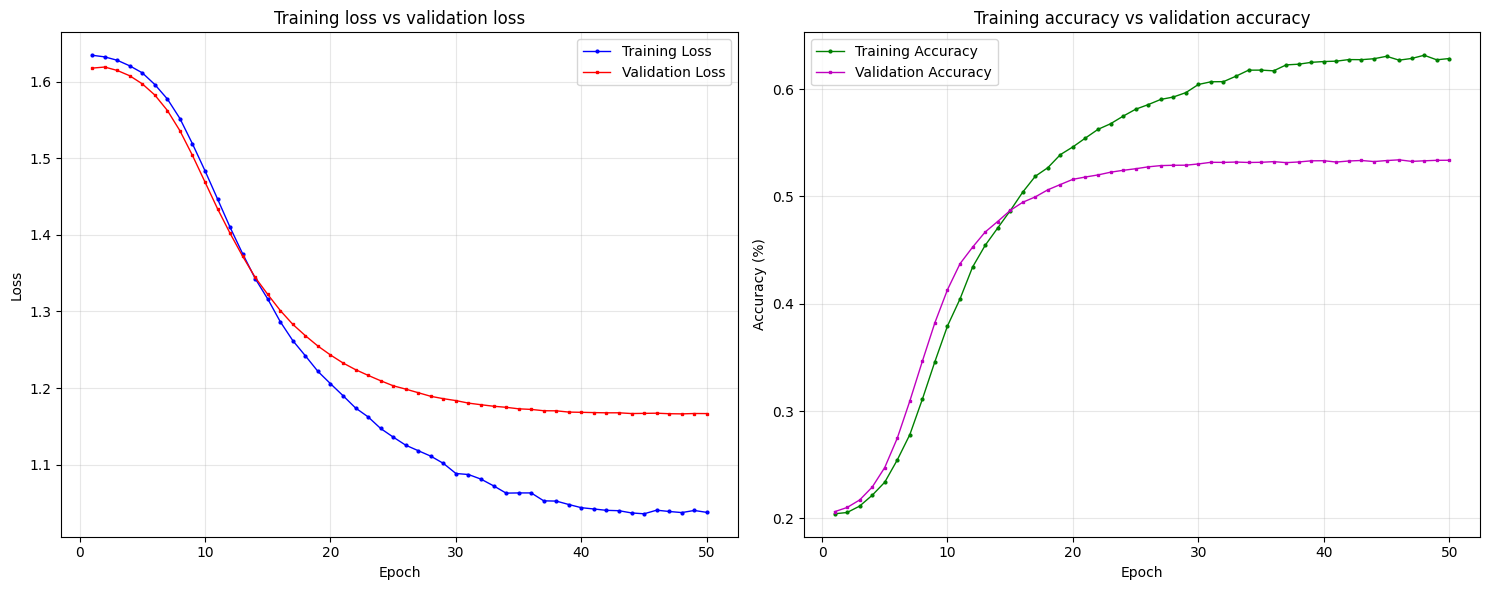

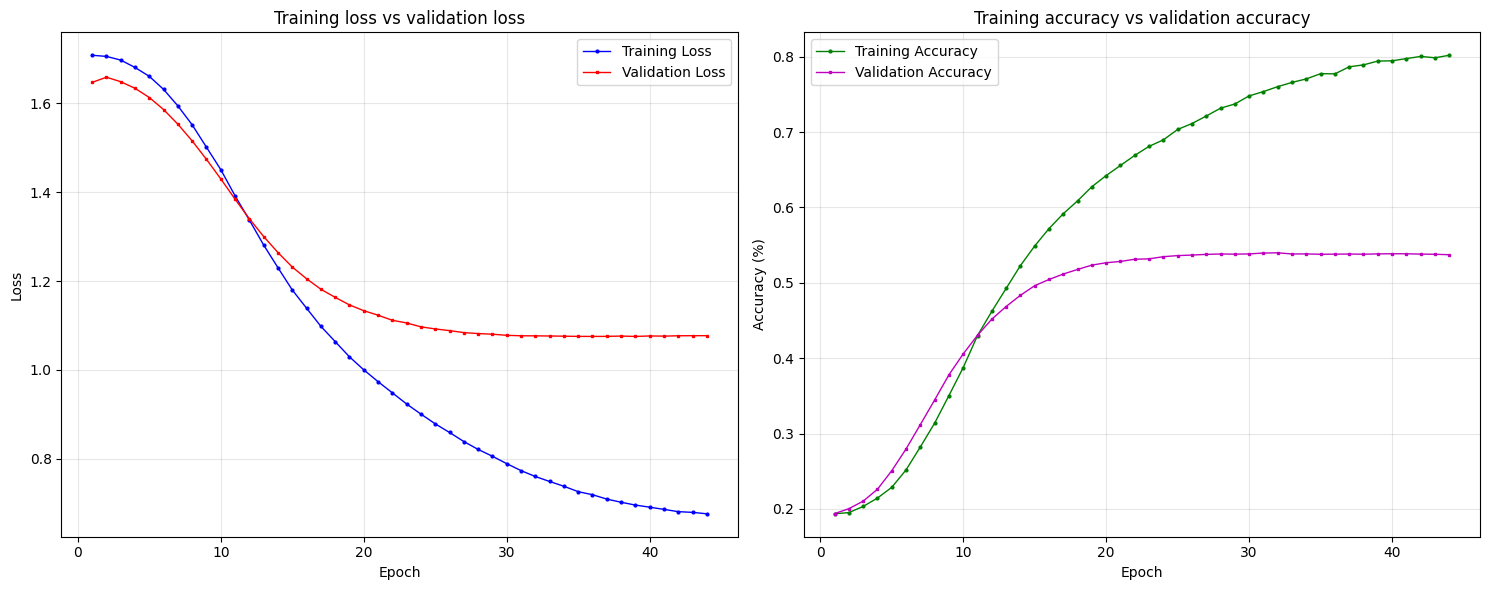

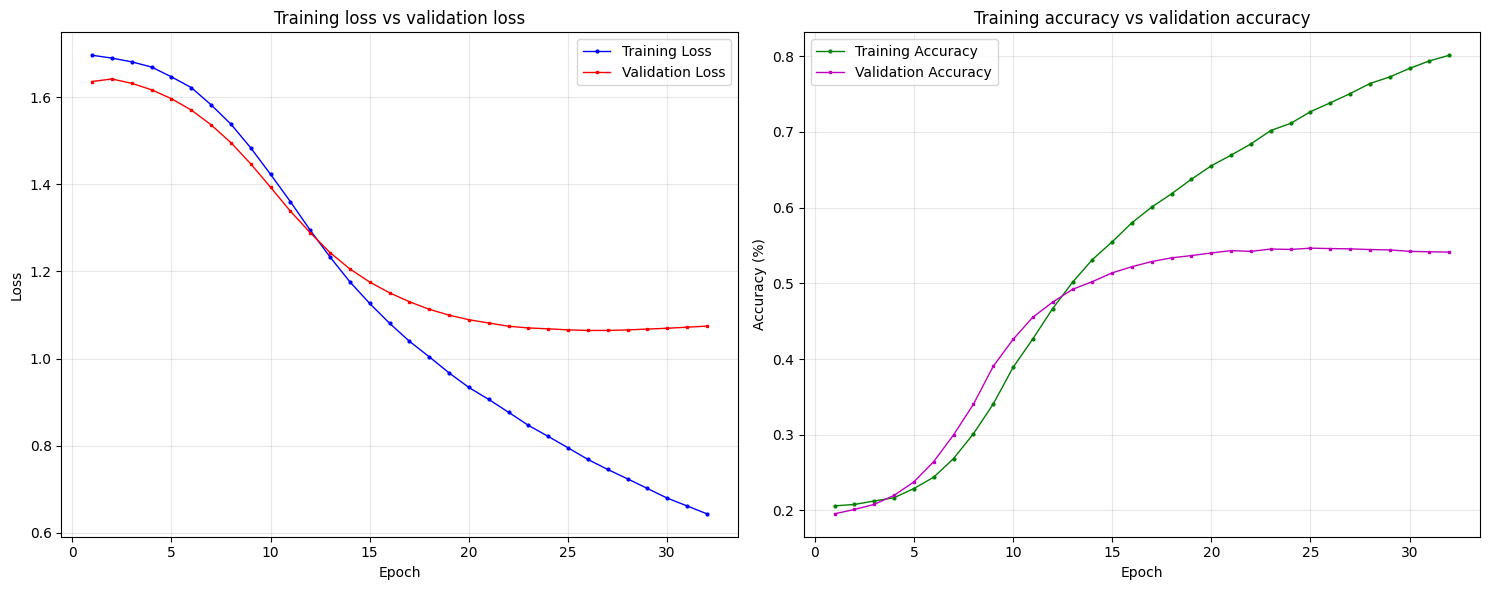

The best model is: model3


In [25]:
# Results viasualization
def create_loss_plot(train_losses,
                     val_losses,
                     train_accuracies,
                     val_accuracies):

  epochs = range(1, len(train_losses) + 1)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


  # Loss plot
  ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=1, marker='o', markersize=2)
  ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=1, marker='s', markersize=2)

  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training loss vs validation loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # Accuracy plot
  ax2.plot(epochs, train_accuracies, 'g-', label='Training Accuracy', linewidth=1, marker='o', markersize=2)
  ax2.plot(epochs, val_accuracies, 'm-', label='Validation Accuracy', linewidth=1, marker='s', markersize=2)

  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.set_title('Training accuracy vs validation accuracy')
  ax2.legend()
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

api = wandb.Api()
runs = api.runs("kacper-pt119-warsaw-university-of-technology/3DifferentNeuralNetsExperiments_v13")

metrics = ["train/loss", "val/loss", "train/accuracy", "val/accuracy"]

all_histories = {}

for run in runs:
  history = run.history(keys=metrics)
  all_histories[run.name] = history

the_best_val_loss_model = None
the_best_val_loss = float("inf")
for name, history in all_histories.items():
  if the_best_val_loss_model is None:
    the_best_val_loss_model = name
    the_best_val_loss = np.min(history["val/loss"].to_list())
  else:
    if np.min(history["val/loss"].to_list()) < the_best_val_loss:
      the_best_val_loss_model = name
      the_best_val_loss = np.min(history["val/loss"].to_list())

  train_losses = history["train/loss"].to_list()
  val_losses   = history["val/loss"].to_list()
  train_acc    = history["train/accuracy"].to_list()
  val_acc      = history["val/accuracy"].to_list()
  create_loss_plot(train_losses, val_losses, train_acc, val_acc)

print(f"The best model is: {the_best_val_loss_model}")



              precision    recall  f1-score   support

           0       0.65      0.72      0.68      3989
           1       0.47      0.45      0.46      4091
           2       0.45      0.39      0.42      3925
           3       0.46      0.44      0.45      4061
           4       0.59      0.66      0.62      3934

    accuracy                           0.53     20000
   macro avg       0.52      0.53      0.53     20000
weighted avg       0.52      0.53      0.53     20000



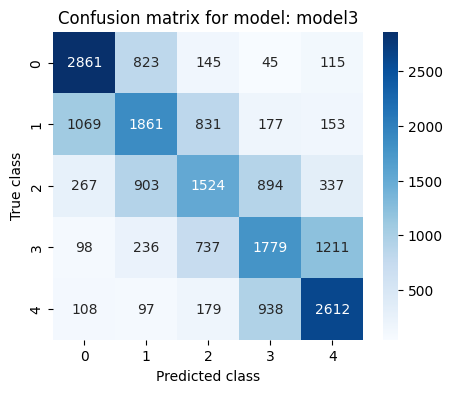

In [26]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model evaluation
def get_data_to_eval(model, data_loader):
  model.eval()
  preds_l = []
  targets_l = []
  with torch.inference_mode():
      for inputs, targets in data_loader:
          device = next(model.parameters()).device
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          preds_l.extend(predicted.cpu().numpy())
          targets_l.extend(targets.cpu().numpy())
  return preds_l, targets_l

the_best_model = classifiers[the_best_val_loss_model]
preds, targets = get_data_to_eval(the_best_model, loaders["test"])
labels = [str(i) for i in range(0,5)]

report = classification_report(targets, preds, target_names = labels)
print(report)

# Confusion matrix
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion matrix for model: {the_best_val_loss_model}')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

A function that finds and displays $k$ elements of the test set for which the model is most wrong, i.e., predicts the smallest probabilities of the true class. Softmax is a strictly increasing function, so it is enough to find elements with the smallest value of unnormalized output from the network (logit) for the true class.

In [ ]:
def show_worst_predictions(model, data_loader, k=10):
    model.eval()
    device = next(model.parameters()).device
    mistakes = []

    with torch.inference_mode():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Get logits for True class
            true_class_logits = logits.gather(1, targets.unsqueeze(1)).squeeze(1)

            for i in range(targets.size(0)):
                mistakes.append((true_class_logits[i].item(), inputs[i].cpu(), targets[i].item(), preds[i].item()))

    mistakes.sort(key=lambda x: x[0])

    print(f"Top {k} the most wrong predicted elements:")
    for i in range(k):
        logit, x, target, pred = mistakes[i]
        print(f"{i+1}. True class: {target}, Predicted class: {pred}, Logit for true class: {logit:.4f}")

    return mistakes[:k]

for name, model in classifiers.items():
  print(f"\nModel: {name}")
  show_worst_predictions(model, loaders["test"])


Model: model2
Top 10 the most wrong predicted elements:
1. True class: 0, Predicted class: 2, Logit for true class: -3.2173
2. True class: 4, Predicted class: 1, Logit for true class: -3.0492
3. True class: 0, Predicted class: 4, Logit for true class: -2.8106
4. True class: 0, Predicted class: 4, Logit for true class: -2.8047
5. True class: 3, Predicted class: 0, Logit for true class: -2.8032
6. True class: 4, Predicted class: 1, Logit for true class: -2.8019
7. True class: 4, Predicted class: 0, Logit for true class: -2.7780
8. True class: 4, Predicted class: 2, Logit for true class: -2.7193
9. True class: 0, Predicted class: 4, Logit for true class: -2.5667
10. True class: 0, Predicted class: 3, Logit for true class: -2.5342
